In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl
%matplotlib widget

In [3]:
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("Dark2")

In [4]:
def deep_learning_cv_score(df, drug_id=None):
    if drug_id:
        df = df[df['drug_id'].str.startswith(str(drug_id))]
    scores_cv_long = []
    if 'score' in df.columns:
        col = 'score'
    else:
        col = 'val_score'
    for i in range(5):
        scores_multi_protein_cv_c = df[df['run'] == f'cv_{i}'].reset_index(
            drop=True)

        max_epoch = scores_multi_protein_cv_c.groupby(
            ['epoch']).median()[col].reset_index()
        max_epoch = np.squeeze(
            max_epoch[max_epoch[col] == max_epoch[col].max()]['epoch'])
        scores_cv_long.append(
            df[(df['run'] == f'cv_{i}')
               & (df['epoch'] == max_epoch)].reset_index(drop=True))
    scores_cv_long = pd.concat(scores_cv_long).drop(['epoch', 'mae'], axis=1)
    scores_cv_long['model'] = 'DL'
    return scores_cv_long

# load data

## RF

In [78]:
wes_df = pd.read_csv("../work_dirs/wes/RandomForest/scores_202006211819_ruv_min_300_eg_id.csv")
wes_df['data'] = 'WES'
print(wes_df['test_corr'].median())
cna_df = pd.read_csv("../work_dirs/cna/RandomForest/scores_202006211819_ruv_min_300_eg_id.csv")
cna_df['data'] = 'Copy Number'
print(cna_df['test_corr'].median())
methy_df = pd.read_csv("../work_dirs/methylation/RandomForest/scores_202006211818_ruv_min_300_eg_id.csv")
methy_df['data'] = 'Methylation'
print(methy_df['test_corr'].median())

rna_df = pd.read_csv("../work_dirs/rna/RandomForest/scores_202006191030_rna_300_eg_id.csv")
rna_df['data'] = 'Transcriptome'
print(rna_df['test_corr'].median())

protein_df = pd.read_csv("../work_dirs/protein/RandomForest/scores_202006181311_ruv_min_300_eg_id.csv")
protein_df['data'] = 'Proteome'
print(protein_df['test_corr'].median())

tissue_df = pd.read_csv("../work_dirs/meta_info/tissue_ic50/RandomForest/scores_202007202320_tissue.csv")
tissue_df['data'] = 'Tissue'

print(tissue_df['test_corr'].median())
tissue_df_en = pd.read_csv("../work_dirs/meta_info/tissue_ic50/ElasticNet/scores_202007311343_tissue.csv")
print(tissue_df_en['test_corr'].median())

mobem_df = pd.read_csv("../work_dirs/mobem/RandomForest/scores_202007202323_mobem_eg_id.csv")
print(mobem_df['test_corr'].median())
mobem_df['data'] = 'mobem'

mobem_df_en = pd.read_csv("../work_dirs/mobem/ElasticNet/scores_202007311324_mobem_eg_id.csv")
print(mobem_df_en['test_corr'].median())

0.08272009824760983
0.3154699049821552
0.5072752701998318
0.5140950194648921
0.5101889609650684
0.4117131718838183
0.38707759984173673
0.40970508937011074
0.3992240527843818


In [50]:
print(wes_df['val_score'].median())
print(cna_df['val_score'].median())
print(methy_df['val_score'].median())
print(rna_df['val_score'].median())
print(protein_df['val_score'].median())

print(tissue_df['val_score'].median())
print(tissue_df_en['val_score'].median())

print(mobem_df['val_score'].median())
print(mobem_df_en['val_score'].median())

0.07431907702415706
0.2679810967647976
0.45492440667527634
0.48787123502783525
0.49318935237415906
0.37469163328077554
0.36319316292496223
0.36999838299378784
0.3495198933647179


In [51]:
print(wes_df[wes_df['drug_id']==1029]['test_corr'])
print(cna_df[cna_df['drug_id']==1029]['test_corr'])
print(methy_df[methy_df['drug_id']==1029]['test_corr'])
print(rna_df[rna_df['drug_id']==1029]['test_corr'])
print(protein_df[protein_df['drug_id']==1029]['test_corr'])

Series([], Name: test_corr, dtype: float64)
Series([], Name: test_corr, dtype: float64)
Series([], Name: test_corr, dtype: float64)
Series([], Name: test_corr, dtype: float64)
Series([], Name: test_corr, dtype: float64)


In [72]:
data = {
    'Tissue': tissue_df['test_corr'].values,
    'mobem': mobem_df['test_corr'].values,
    'WES': wes_df['test_corr'].values,
    'Copy Number': cna_df['test_corr'].values,
    'Methylation': methy_df['test_corr'].values,
    'Transcriptome': rna_df['test_corr'].values,
    'Proteome': protein_df['test_corr'].values
}
data_list = list(data.keys())

## DL

In [53]:
def multidrug_score(scores_multi):
    scores_multi_test = scores_multi[
    scores_multi['run'] == 'test'].reset_index(drop=True)

    max_epoch = scores_multi_test.groupby(
        ['epoch']).median()['corr'].reset_index()

    print(max_epoch[max_epoch['corr'] == max_epoch['corr'].max()])
    cv_max_epoches = []
    cv_max_epoches_scores = []
    for i in range(5):
        scores_multi_cv = scores_multi[
            scores_multi['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_cv.groupby(
            ['epoch']).median()['corr'].reset_index()
        cv_max_epoches_scores.append(max_epoch['corr'].max())
        max_epoch = np.squeeze(
            max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'])
        cv_max_epoches.append(max_epoch)
    print(cv_max_epoches)
    print(np.average(cv_max_epoches_scores))
    cv_epoch = int(np.mean(cv_max_epoches))
    print(f"cv eooch {cv_epoch}")
    scores_multi_cv = scores_multi[
        (scores_multi['run'] != 'test')
        & (scores_multi['epoch'] == cv_epoch)].drop(
            ['epoch'], axis=1).reset_index(drop=True)
    print(
        scores_multi_cv.groupby(['drug_id']).mean()['corr'].median())

In [54]:
def multidrug_score_one_drug(scores_multi, drug_id):
    scores_multi = scores_multi[scores_multi['drug_id'] == drug_id]
    scores_multi_test = scores_multi[scores_multi['run'] ==
                                     'test'].reset_index(drop=True)

    max_epoch = scores_multi_test.groupby(['epoch'
                                           ]).median()['corr'].reset_index()

    print(max_epoch[max_epoch['corr'] == max_epoch['corr'].max()])
    cv_max_epoches = []
    cv_max_epoches_scores = []
    for i in range(5):
        scores_multi_cv = scores_multi[scores_multi['run'] ==
                                       f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_cv.groupby(['epoch'
                                             ]).median()['corr'].reset_index()
        cv_max_epoches_scores.append(max_epoch['corr'].max())
        max_epoch = np.squeeze(
            max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'])
        cv_max_epoches.append(max_epoch)
    print(cv_max_epoches)
    print(np.average(cv_max_epoches_scores))
    cv_epoch = int(np.mean(cv_max_epoches))
    print(f"cv eooch {cv_epoch}")


In [55]:
scores_multi_tissue = pd.read_csv(
    "../work_dirs/meta_info/tissue_ic50/MultiDrug/scores_202007311540_res_eg_id.csv")
multidrug_score(scores_multi_tissue)
tissue_epoch = 90

    epoch      corr
87     88  0.413652
[122, 81, 74, 107, 117]
0.381710948367155
cv eooch 100
0.3831378679311406


In [56]:
scores_multi_mobem = pd.read_csv(
    "../work_dirs/mobem/MultiDrug/scores_202007311540_res_eg_id.csv")
multidrug_score(scores_multi_mobem)
mobem_epoch = 50

    epoch      corr
47     48  0.392914
[64, 60, 104, 59, 86]
0.34052158898063695
cv eooch 74
0.3361292405812141


In [57]:
scores_multi_wes = pd.read_csv(
    "../work_dirs/wes/MultiDrug/scores_202006182116_res_eg_id.csv")
multidrug_score(scores_multi_wes)
wes_epoch = 160

    epoch      corr
91     92  0.148591
[156, 233, 97, 86, 250]
0.14466397323006314
cv eooch 164
0.12235275135072676


In [58]:
scores_multi_cna = pd.read_csv(
    "../work_dirs/cna/MultiDrug/scores_202006190142_res_eg_id.csv")
multidrug_score(scores_multi_cna)
cna_epoch = 270

     epoch      corr
295    296  0.367152
[240, 282, 294, 285, 278]
0.3246442504658926
cv eooch 275
0.30834946984118006


In [59]:
scores_multi_methylation = pd.read_csv(
    "../work_dirs/methylation/MultiDrug/scores_202006190143_res_eg_id.csv")
multidrug_score(scores_multi_methylation)
methylation_epoch = 300

     epoch      corr
283    284  0.512108
[404, 299, 495, 463, 493]
0.4747521515542289
cv eooch 430
0.4687294939111789


In [60]:
scores_multi_rna = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006181624_res_eg_id.csv")
multidrug_score(scores_multi_rna)
rna_epoch = 240

     epoch      corr
229    230  0.528858
[287, 195, 271, 207, 297]
0.4994019394509942
cv eooch 251
0.49077381190774894


In [61]:
scores_multi_protein = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006191021_resx_ruv_zero_300_eg_id.csv")
multidrug_score(scores_multi_protein)
protein_epoch = 70

    epoch     corr
65     66  0.51924
[65, 72, 99, 87, 70]
0.49822498229017914
cv eooch 78
0.49630605600234623


In [62]:
scores_multi_mobem_test = scores_multi_mobem[
    (scores_multi_mobem['run'] == 'test')
    & (scores_multi_mobem['epoch'] == mobem_epoch)][['drug_id',
                                           'corr']].rename(columns={
                                               'corr': 'test_corr'
                                           }).reset_index(drop=True)
scores_multi_mobem_test['data'] = 'mobem'

In [83]:
scores_multi_tissue_test = scores_multi_tissue[
    (scores_multi_tissue['run'] == 'test')
    & (scores_multi_tissue['epoch'] == tissue_epoch)][['drug_id',
                                           'corr']].rename(columns={
                                               'corr': 'test_corr'
                                           }).reset_index(drop=True)
scores_multi_tissue_test['data'] = 'Tissue'

In [64]:


scores_multi_wes_test = scores_multi_wes[
    (scores_multi_wes['run'] == 'test')
    & (scores_multi_wes['epoch'] == wes_epoch)][['drug_id',
                                           'corr']].rename(columns={
                                               'corr': 'test_corr'
                                           }).reset_index(drop=True)
scores_multi_wes_test['data'] = 'WES'
scores_multi_cna_test = scores_multi_cna[
    (scores_multi_cna['run'] == 'test')
    & (scores_multi_cna['epoch'] == cna_epoch)][['drug_id',
                                           'corr']].rename(columns={
                                               'corr': 'test_corr'
                                           }).reset_index(drop=True)
scores_multi_cna_test['data'] = 'Copy Number'
scores_multi_methylation_test = scores_multi_methylation[
    (scores_multi_methylation['run'] == 'test')
    & (scores_multi_methylation['epoch'] == methylation_epoch)][['drug_id',
                                           'corr']].rename(columns={
                                               'corr': 'test_corr'
                                           }).reset_index(drop=True)
scores_multi_methylation_test['data'] = 'Methylation'
scores_multi_rna_test = scores_multi_rna[
    (scores_multi_rna['run'] == 'test')
    & (scores_multi_rna['epoch'] == rna_epoch)][['drug_id',
                                           'corr']].rename(columns={
                                               'corr': 'test_corr'
                                           }).reset_index(drop=True)
scores_multi_rna_test['data'] = 'Transcriptome'
scores_multi_protein_test = scores_multi_protein[
    (scores_multi_protein['run'] == 'test')
    & (scores_multi_protein['epoch'] == protein_epoch)][['drug_id',
                                           'corr']].rename(columns={
                                               'corr': 'test_corr'
                                           }).reset_index(drop=True)
scores_multi_protein_test['data'] = 'Proteome'

# pairwise correlation

In [17]:
for i in range(len(data_list)):
    for j in range(i+1, len(data_list)):
        print(
            f"{data_list[i]}/{data_list[j]} R: {pearsonr(data[data_list[i]], data[data_list[j]])[0]:.4f}/{spearmanr(data[data_list[i]], data[data_list[j]])[0]:.4f}"
        )

WES/Copy Number R: 0.3742/0.3458
WES/Methylation R: 0.3097/0.3057
WES/Transcriptome R: 0.3241/0.3038
WES/Proteome R: 0.3143/0.2986
Copy Number/Methylation R: 0.7641/0.7704
Copy Number/Transcriptome R: 0.7869/0.7950
Copy Number/Proteome R: 0.8060/0.8176
Methylation/Transcriptome R: 0.9380/0.9384
Methylation/Proteome R: 0.8927/0.8938
Transcriptome/Proteome R: 0.9244/0.9299


# box plot

In [ ]:
single_omic = pd.concat([wes_df, cna_df, methy_df, rna_df, protein_df])

## RF box

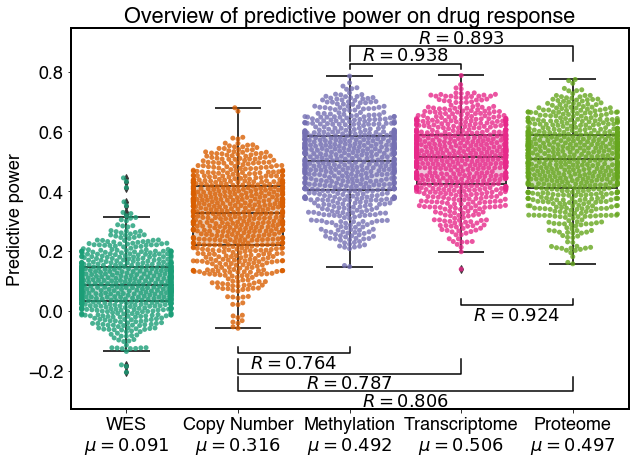

In [66]:
ga = sns.boxplot('data',
                 'test_corr',
                 data=single_omic,
                 orient='v',
                 linewidth=2)
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('data', 'test_corr', data=single_omic, orient='vh', alpha=.8)

x1, x2 = 2, 3  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = single_omic['test_corr'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5,
         y + w + 0.025,
         r"$R=0.938}$",
         ha='center',
         va='center',
         color=col)

x1, x2 = 2, 4  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = single_omic['test_corr'].max() + 0.05, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5,
         y + w + 0.025,
         r"$R=0.893$",
         ha='center',
         va='center',
         color=col)

x1, x2 = 1, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = -0.1 - 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y - w, y - w, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5,
         y - w - 0.035,
         r"$R=0.764}$",
         ha='center',
         va='center',
         color=col)
x1, x2 = 1, 3  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = -0.1 - 0.06, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y - w, y - w, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5,
         y - w - 0.035,
         r"$R=0.787}$",
         ha='center',
         va='center',
         color=col)
x1, x2 = 1, 4  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = -0.1 - 0.12, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y - w, y - w, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5,
         y - w - 0.035,
         r"$R=0.806}$",
         ha='center',
         va='center',
         color=col)

x1, x2 = 3, 4  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = 0.1 - 0.06, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y - w, y - w, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5,
         y - w - 0.035,
         r"$R=0.924}$",
         ha='center',
         va='center',
         color=col)

for i in range(len(data_list)):
    plt.text(
        i,
        -0.45,
        f"$\mu={single_omic[single_omic['data']==data_list[i]]['test_corr'].mean():.3f}$",
        ha='center',
        va='center')

plt.ylabel("Predictive power")
plt.xlabel("")
plt.title("Overview of predictive power on drug response")
plt.savefig("../plots/Fig4A.pdf", dpi=500)

# bar plot

## test

In [84]:
single_omic_rf = pd.concat(
    [tissue_df, mobem_df, wes_df, cna_df, methy_df, rna_df,
     protein_df])[['drug_id', 'test_corr', 'data']]
single_omic_rf['model'] = 'RF'

In [85]:
single_omic_dl = pd.concat([
    scores_multi_tissue_test, scores_multi_mobem_test, scores_multi_wes_test,
    scores_multi_cna_test, scores_multi_methylation_test,
    scores_multi_rna_test, scores_multi_protein_test
])
single_omic_dl['model'] = 'DL'

In [86]:
single_omic_rf_dl = pd.concat([single_omic_rf, single_omic_dl])

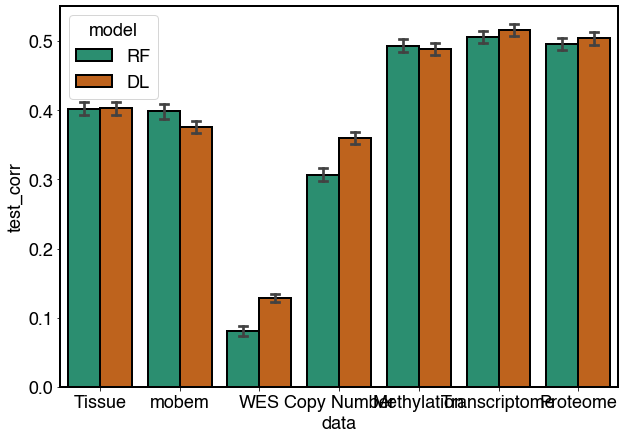

In [87]:
sns.barplot('data',
            'test_corr',
            hue='model',
            data=single_omic_rf_dl,
            orient='v',
            linewidth=2,
            capsize=.1,
            edgecolor='black')

In [119]:
print(single_omic_rf_dl[(single_omic_rf_dl['data']=='Proteome')&(single_omic_rf_dl['model']=='RF')].mean())

print(single_omic_rf_dl[(single_omic_rf_dl['data']=='Proteome')&(single_omic_rf_dl['model']=='DL')].mean())

test_corr    0.495846
dtype: float64
test_corr    0.503944
dtype: float64


## test + CV

### load CV data

In [24]:
col = ['drug_id', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']

#### RF

In [88]:
scores_rf_tissue_cv = pd.read_csv(
    "../work_dirs/meta_info/tissue_ic50/RandomForest/scores_202007202320_tissue.csv"
)[col]
scores_rf_tissue_cv_long = pd.melt(
    scores_rf_tissue_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_tissue_cv_long['model'] = 'RF'
scores_rf_tissue_cv_long['data'] = 'Tissue'

In [89]:
scores_rf_mobem_cv = pd.read_csv(
    "../work_dirs/mobem/RandomForest/scores_202007202323_mobem_eg_id.csv"
)[col]
scores_rf_mobem_cv_long = pd.melt(
    scores_rf_mobem_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_mobem_cv_long['model'] = 'RF'
scores_rf_mobem_cv_long['data'] = 'mobem'

In [90]:
scores_rf_wes_cv = pd.read_csv(
    "../work_dirs/wes/RandomForest/scores_202006211819_ruv_min_300_eg_id.csv"
)[col]
scores_rf_wes_cv_long = pd.melt(
    scores_rf_wes_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_wes_cv_long['model'] = 'RF'
scores_rf_wes_cv_long['data'] = 'WES'

In [91]:
scores_rf_cna_cv = pd.read_csv(
    "../work_dirs/cna/RandomForest/scores_202006211819_ruv_min_300_eg_id.csv"
)[col]
scores_rf_cna_cv_long = pd.melt(
    scores_rf_cna_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_cna_cv_long['model'] = 'RF'
scores_rf_cna_cv_long['data'] = 'Copy Number'

In [92]:
scores_rf_methylation_cv = pd.read_csv(
    "../work_dirs/methylation/RandomForest/scores_202006211818_ruv_min_300_eg_id.csv"
)[col]
scores_rf_methylation_cv_long = pd.melt(
    scores_rf_methylation_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_methylation_cv_long['model'] = 'RF'
scores_rf_methylation_cv_long['data'] = 'Methylation'

In [93]:
scores_rf_rna_cv = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006191030_rna_300_eg_id.csv"
)[col]
scores_rf_rna_cv_long = pd.melt(
    scores_rf_rna_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_rna_cv_long['model'] = 'RF'
scores_rf_rna_cv_long['data'] = 'Transcriptome'

In [94]:
scores_rf_protein_cv = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006181311_ruv_min_300_eg_id.csv"
)[col]
scores_rf_protein_cv_long = pd.melt(
    scores_rf_protein_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_protein_cv_long['model'] = 'RF'
scores_rf_protein_cv_long['data'] = 'Proteome'

#### DL

In [95]:
scores_multi_tissue_cv = pd.read_csv(
    "../work_dirs/meta_info/tissue_ic50/MultiDrug/scores_202007311540_res_eg_id.csv")
scores_multi_tissue_cv = scores_multi_tissue_cv[
    scores_multi_tissue_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})
scores_dl_tissue_cv_long = deep_learning_cv_score(scores_multi_tissue_cv)
scores_dl_tissue_cv_long['data'] = 'Tissue'

In [96]:
scores_multi_mobem_cv = pd.read_csv(
    "../work_dirs/mobem/MultiDrug/scores_202007311540_res_eg_id.csv")
scores_multi_mobem_cv = scores_multi_mobem_cv[
    scores_multi_mobem_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})
scores_dl_mobem_cv_long = deep_learning_cv_score(scores_multi_mobem_cv)
scores_dl_mobem_cv_long['data'] = 'mobem'

In [97]:
scores_multi_wes_cv = pd.read_csv(
    "../work_dirs/wes/MultiDrug/scores_202006182116_res_eg_id.csv")
scores_multi_wes_cv = scores_multi_wes_cv[
    scores_multi_wes_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})
scores_dl_wes_cv_long = deep_learning_cv_score(scores_multi_wes_cv)
scores_dl_wes_cv_long['data'] = 'WES'

In [98]:
scores_multi_cna_cv = pd.read_csv(
    "../work_dirs/cna/MultiDrug/scores_202006190142_res_eg_id.csv")
scores_multi_cna_cv = scores_multi_cna_cv[
    scores_multi_cna_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})
scores_dl_cna_cv_long = deep_learning_cv_score(scores_multi_cna_cv)
scores_dl_cna_cv_long['data'] = 'Copy Number'

In [99]:
scores_multi_methylation_cv = pd.read_csv(
    "../work_dirs/methylation/MultiDrug/scores_202006190143_res_eg_id.csv")
scores_multi_methylation_cv = scores_multi_methylation_cv[
    scores_multi_methylation_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})
scores_dl_methylation_cv_long = deep_learning_cv_score(scores_multi_methylation_cv)
scores_dl_methylation_cv_long['data'] = 'Methylation'

In [100]:
scores_multi_rna_cv = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006181624_res_eg_id.csv")
scores_multi_rna_cv = scores_multi_rna_cv[
    scores_multi_rna_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})
scores_dl_rna_cv_long = deep_learning_cv_score(scores_multi_rna_cv)
scores_dl_rna_cv_long['data'] = 'Transcriptome'

In [101]:
scores_multi_protein_cv = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006191021_resx_ruv_zero_300_eg_id.csv")
scores_multi_protein_cv = scores_multi_protein_cv[
    scores_multi_protein_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})
scores_dl_protein_cv_long = deep_learning_cv_score(scores_multi_protein_cv)
scores_dl_protein_cv_long['data'] = 'Proteome'

### plot

In [102]:
df_cv_all = pd.concat([
    scores_rf_wes_cv_long, scores_rf_cna_cv_long,
    scores_rf_methylation_cv_long, scores_rf_rna_cv_long, scores_rf_protein_cv_long,
    scores_dl_wes_cv_long, scores_dl_cna_cv_long,
    scores_dl_methylation_cv_long, scores_dl_rna_cv_long, scores_dl_protein_cv_long
])

In [103]:
df_cv_all = pd.concat([
    scores_rf_mobem_cv_long, scores_rf_tissue_cv_long,
    scores_rf_wes_cv_long, scores_rf_cna_cv_long,
    scores_rf_methylation_cv_long, scores_rf_rna_cv_long, scores_rf_protein_cv_long,
    scores_dl_mobem_cv_long, scores_dl_tissue_cv_long,
    scores_dl_wes_cv_long, scores_dl_cna_cv_long,
    scores_dl_methylation_cv_long, scores_dl_rna_cv_long, scores_dl_protein_cv_long
])

In [104]:
df_cv_test_all = pd.concat([
    df_cv_all.drop(['run'], axis=1).rename(columns={'val_score': 'score'}),
    single_omic_rf_dl.rename(columns={'test_corr': 'score'})
])

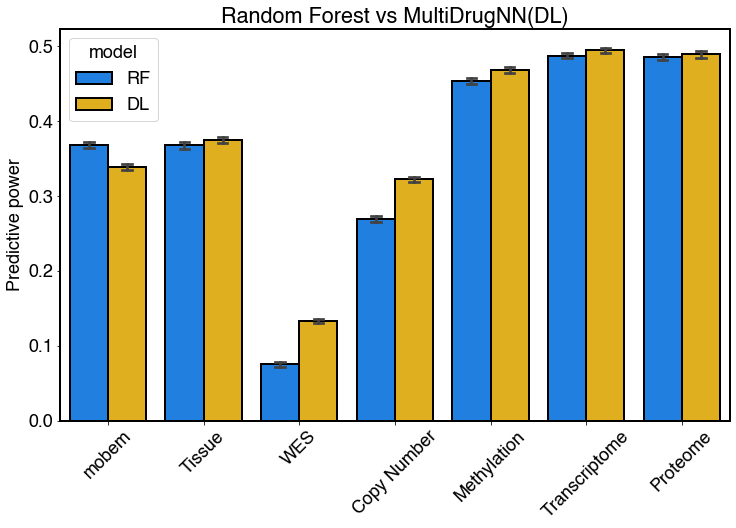

In [110]:
fig = plt.figure(figsize=(12,8))
sns.barplot('data',
            'score',
            hue='model',
            data=df_cv_test_all,
            orient='v',
            linewidth=2,
            capsize=.1,
            palette=['#007fff','#ffbf00'],
            edgecolor='black')
plt.ylabel("Predictive power")
plt.xlabel("")
plt.title("Random Forest vs MultiDrugNN(DL)")
fig.autofmt_xdate(rotation=45, ha='center')
plt.savefig("../plots/drug/Fig4A.pdf", dpi=500)

In [114]:
print(df_cv_test_all[(df_cv_test_all['data']=='WES')&(df_cv_test_all['model']=='RF')].mean())

print(df_cv_test_all[(df_cv_test_all['data']=='WES')&(df_cv_test_all['model']=='DL')].mean())

score    0.075124
dtype: float64
score    0.133156
dtype: float64


In [116]:
print(df_cv_test_all[(df_cv_test_all['data']=='Proteome')&(df_cv_test_all['model']=='RF')].mean())

print(df_cv_test_all[(df_cv_test_all['data']=='Proteome')&(df_cv_test_all['model']=='DL')].mean())

score    0.485037
dtype: float64
score    0.488701
dtype: float64


# specific drugs

## Motesanib - 1029

In [23]:
def single_omic_score(df, drug_id, test_epoch=None, data='WES'):
    df = df[df['drug_id'].str.startswith(str(drug_id))]
    df = df.rename(columns={'corr': 'score'})
    cv_scores = deep_learning_cv_score(
        df[df['run'] != 'test'].reset_index(drop=True), drug_id)
    test_score = df[(df['run'] == 'test')
                    & (df['epoch'] == test_epoch)]['score'].values[0]
    test_df = pd.DataFrame({
        'drug_id': [drug_id],
        'run': ['test'],
        'score': [test_score],
        'model': ['DL']
    })
    res = pd.concat([cv_scores, test_df])
    res['data'] = data
    return res

In [40]:
drug_id = '1029;Motesanib;GDSC2'
combined = pd.concat([
    single_omic_score(scores_multi_wes,
                      drug_id,
                      test_epoch=200,
                      data="WES"),
    single_omic_score(scores_multi_cna,
                      drug_id,
                      test_epoch=260,
                      data="CNA"),
    single_omic_score(scores_multi_methylation,
                      drug_id,
                      test_epoch=385,
                      data="Methylation"),
    single_omic_score(scores_multi_rna,
                      drug_id,
                      test_epoch=210,
                      data="RNA"),
    single_omic_score(scores_multi_protein,
                      drug_id,
                      test_epoch=70,
                      data="Protein")
])

In [43]:
drug_id = '1008;Methotrexate;GDSC2'
combined = pd.concat([
    single_omic_score(scores_multi_wes,
                      drug_id,
                      test_epoch=200,
                      data="WES"),
    single_omic_score(scores_multi_cna,
                      drug_id,
                      test_epoch=260,
                      data="CNA"),
    single_omic_score(scores_multi_methylation,
                      drug_id,
                      test_epoch=385,
                      data="Methylation"),
    single_omic_score(scores_multi_rna,
                      drug_id,
                      test_epoch=210,
                      data="RNA"),
    single_omic_score(scores_multi_protein,
                      drug_id,
                      test_epoch=70,
                      data="Protein")
])

In [45]:
drug_id = '2255;RK-33;GDSC2'
combined = pd.concat([
    single_omic_score(scores_multi_wes,
                      drug_id,
                      test_epoch=200,
                      data="WES"),
    single_omic_score(scores_multi_cna,
                      drug_id,
                      test_epoch=260,
                      data="CNA"),
    single_omic_score(scores_multi_methylation,
                      drug_id,
                      test_epoch=385,
                      data="Methylation"),
    single_omic_score(scores_multi_rna,
                      drug_id,
                      test_epoch=210,
                      data="RNA"),
    single_omic_score(scores_multi_protein,
                      drug_id,
                      test_epoch=70,
                      data="Protein")
])

Text(0.5, 1.0, 'Predictive power comparison for 2255;RK-33;GDSC2')

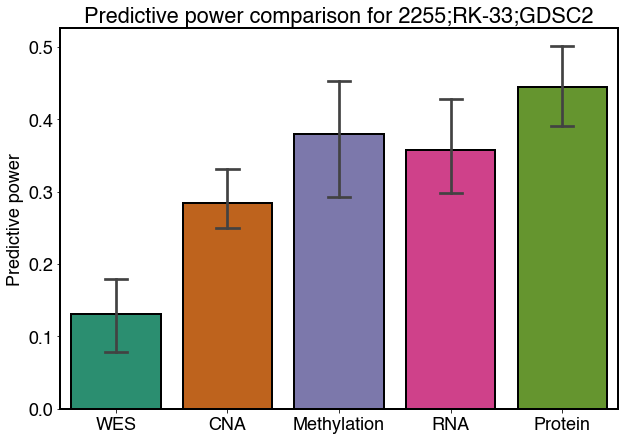

In [46]:
sns.barplot(x='data',
            y='score',
            data=combined,
            capsize=.2,
            linewidth=2,
            edgecolor="black")
plt.ylabel("Predictive power")
plt.xlabel("")
plt.title(f"Predictive power comparison for {drug_id}")
# plt.savefig(f"../plots/drug/{drug_id}_omic.pdf", dpi=500)